# Purpose: Solve the electronic structure problem with quantum computers + classic interpolation

## Step 1: create a quantum circuit that can estimate the eigenvalue of any Hermitian matrix

In [1]:
import sys
sys.path.append('..\\')
import scipy
import numpy as np
from scripts.algo.iterative_phase_estimation import iterative_phase_estimation_v2
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt
import random
from scripts.algo.qdrift import QDrift

ModuleNotFoundError: No module named 'scripts.algo.iterative_phase_estimation'

Given an arbitray Hermintian matrix $H_j$ let us construct a quantum circuit that uses the gate representation of the 
unitary matrix $e^{iH_j}$ to estimate the eigenvalues of $H_j$.

We take advantage of the "phase kickback" phenomenon where the phase of the control qubit is affected by the target qubit.
 
Thus, in addition to the circuit itself, we need to prepare a state $\psi$ which must be an eigenstate of $H_j$.

In [2]:
# Generate a random 2x2 Hermitian matrix with real, non-negative eigenvalues
def generate_random_hermitian(print_output=False):
    while True:
        a = np.random.rand()
        b = np.random.rand()
        c = np.random.rand()
        d = np.random.rand()
        
        # Construct the Hermitian matrix
        hermitian_matrix = np.array([[a, b + 1j * c], [b - 1j * c, d]])
        
        # Calculate eigenvalues
        eigenvalues, _ = np.linalg.eig(hermitian_matrix)
        
        # Check if the matrix is Hermitian and has real, non-negative eigenvalues
        if np.all(np.isreal(eigenvalues)) and np.all(eigenvalues >= 0):
            if print_output:
                print(f'Hermitian matrix: \n{hermitian_matrix}')
                print(f'Eigenvalues: {eigenvalues}')
            return hermitian_matrix

# Example usage
generate_random_hermitian()



array([[0.6927137 +0.j        , 0.21550636+0.16307792j],
       [0.21550636-0.16307792j, 0.22075393+0.j        ]])

Hermitian matrix: 
[[0.28334101+0.j         0.15653941+0.00506965j]
 [0.15653941-0.00506965j 0.58814866+0.j        ]]
Eigenvalues: [0.2172106 +0.j 0.65427907+0.j]
current number of evaluations: 1
{'0': 1}
1.0
estimation: 0.0 
 exact answer: 0.21721059769073114
current number of evaluations: 11
{'0': 11}
1.0
estimation: 0.0 
 exact answer: 0.21721059769073114
current number of evaluations: 21
{'0': 21}
1.0
estimation: 0.0 
 exact answer: 0.21721059769073114
current number of evaluations: 31
{'0': 31}
1.0
estimation: 0.0 
 exact answer: 0.21721059769073114
current number of evaluations: 41
{'0': 41}
1.0
estimation: 0.0 
 exact answer: 0.21721059769073114
current number of evaluations: 51
{'0': 51}
1.0
estimation: 0.0 
 exact answer: 0.21721059769073114
current number of evaluations: 61
{'0': 61}
1.0
estimation: 0.0 
 exact answer: 0.21721059769073114
current number of evaluations: 71


C:\Users\u1037737\AppData\Local\Temp\ipykernel_58824\1436623017.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  print(f"estimation: {estimated_eigenvalue} \n exact answer: {float(min(exact_eigenvalue))}")


{'0': 70, '1': 1}
0.9859154929577465
estimation: 0.23791706740640342 
 exact answer: 0.21721059769073114
current number of evaluations: 81
{'0': 80, '1': 1}
0.9876543209876543
estimation: 0.22268202868192846 
 exact answer: 0.21721059769073114
current number of evaluations: 91
{'0': 91}
1.0
estimation: 0.0 
 exact answer: 0.21721059769073114
current number of evaluations: 101
{'0': 99, '1': 2}
0.9801980198019802
estimation: 0.28237623523407457 
 exact answer: 0.21721059769073114
current number of evaluations: 111
{'0': 109, '1': 2}
0.9819819819819819
estimation: 0.26927522322650016 
 exact answer: 0.21721059769073114
current number of evaluations: 121
{'0': 120, '1': 1}
0.9917355371900827
estimation: 0.18206955607482952 
 exact answer: 0.21721059769073114
current number of evaluations: 131
{'1': 3, '0': 128}
0.9770992366412213
estimation: 0.3038272235696062 
 exact answer: 0.21721059769073114
current number of evaluations: 141
{'0': 140, '1': 1}
0.9929078014184397
estimation: 0.1686301

C:\Users\u1037737\AppData\Local\Temp\ipykernel_58824\1436623017.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  all_experiments.append((iterations, estimations, float(min(exact_eigenvalue))))


{'0': 61}
1.0
estimation: 0.0 
 exact answer: 0.02504166689644155
current number of evaluations: 71
{'0': 71}
1.0
estimation: 0.0 
 exact answer: 0.02504166689644155
current number of evaluations: 81
{'0': 81}
1.0
estimation: 0.0 
 exact answer: 0.02504166689644155
current number of evaluations: 91
{'0': 91}
1.0
estimation: 0.0 
 exact answer: 0.02504166689644155
current number of evaluations: 101
{'0': 101}
1.0
estimation: 0.0 
 exact answer: 0.02504166689644155
current number of evaluations: 111
{'0': 111}
1.0
estimation: 0.0 
 exact answer: 0.02504166689644155
current number of evaluations: 121
{'0': 121}
1.0
estimation: 0.0 
 exact answer: 0.02504166689644155
current number of evaluations: 131
{'0': 131}
1.0
estimation: 0.0 
 exact answer: 0.02504166689644155
current number of evaluations: 141
{'0': 141}
1.0
estimation: 0.0 
 exact answer: 0.02504166689644155
current number of evaluations: 151
{'0': 151}
1.0
estimation: 0.0 
 exact answer: 0.02504166689644155
current number of eval

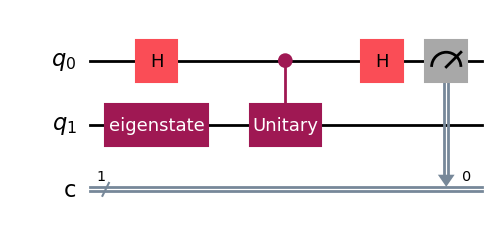

In [3]:
from qiskit_aer import Aer

num_random_matrices = 6
max_iterations = 10000
selected_backend = Aer.get_backend('qasm_simulator')

all_experiments = []

for i in range(num_random_matrices):

    test_hermitian = generate_random_hermitian()

    # for testing purposes, we also analytically calculate the eigenvalues
    exact_eigenvalue, eigenvectors= scipy.linalg.eig(test_hermitian)

    U = scipy.linalg.expm(1j * test_hermitian) 

    # pick eigenstate that corresponds to smallest eigenvalue
    eigenstate = eigenvectors[:, np.argmin(exact_eigenvalue)]
    iterations = []
    estimations = []

    for j in range(1, max_iterations, 10):
        print(f'current number of evaluations: {j}')
        p_0, qc = iterative_phase_estimation_v2(U=U, eigenstate=eigenstate, num_evals=j, backend=selected_backend, num_qubits=1)
        print(p_0)
        estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0)) # 
        iterations.append(j)
        estimations.append(estimated_eigenvalue)
        print(f"estimation: {estimated_eigenvalue} \n exact answer: {float(min(exact_eigenvalue))}")
    
    all_experiments.append((iterations, estimations, float(min(exact_eigenvalue))))

qc.draw(output='mpl')


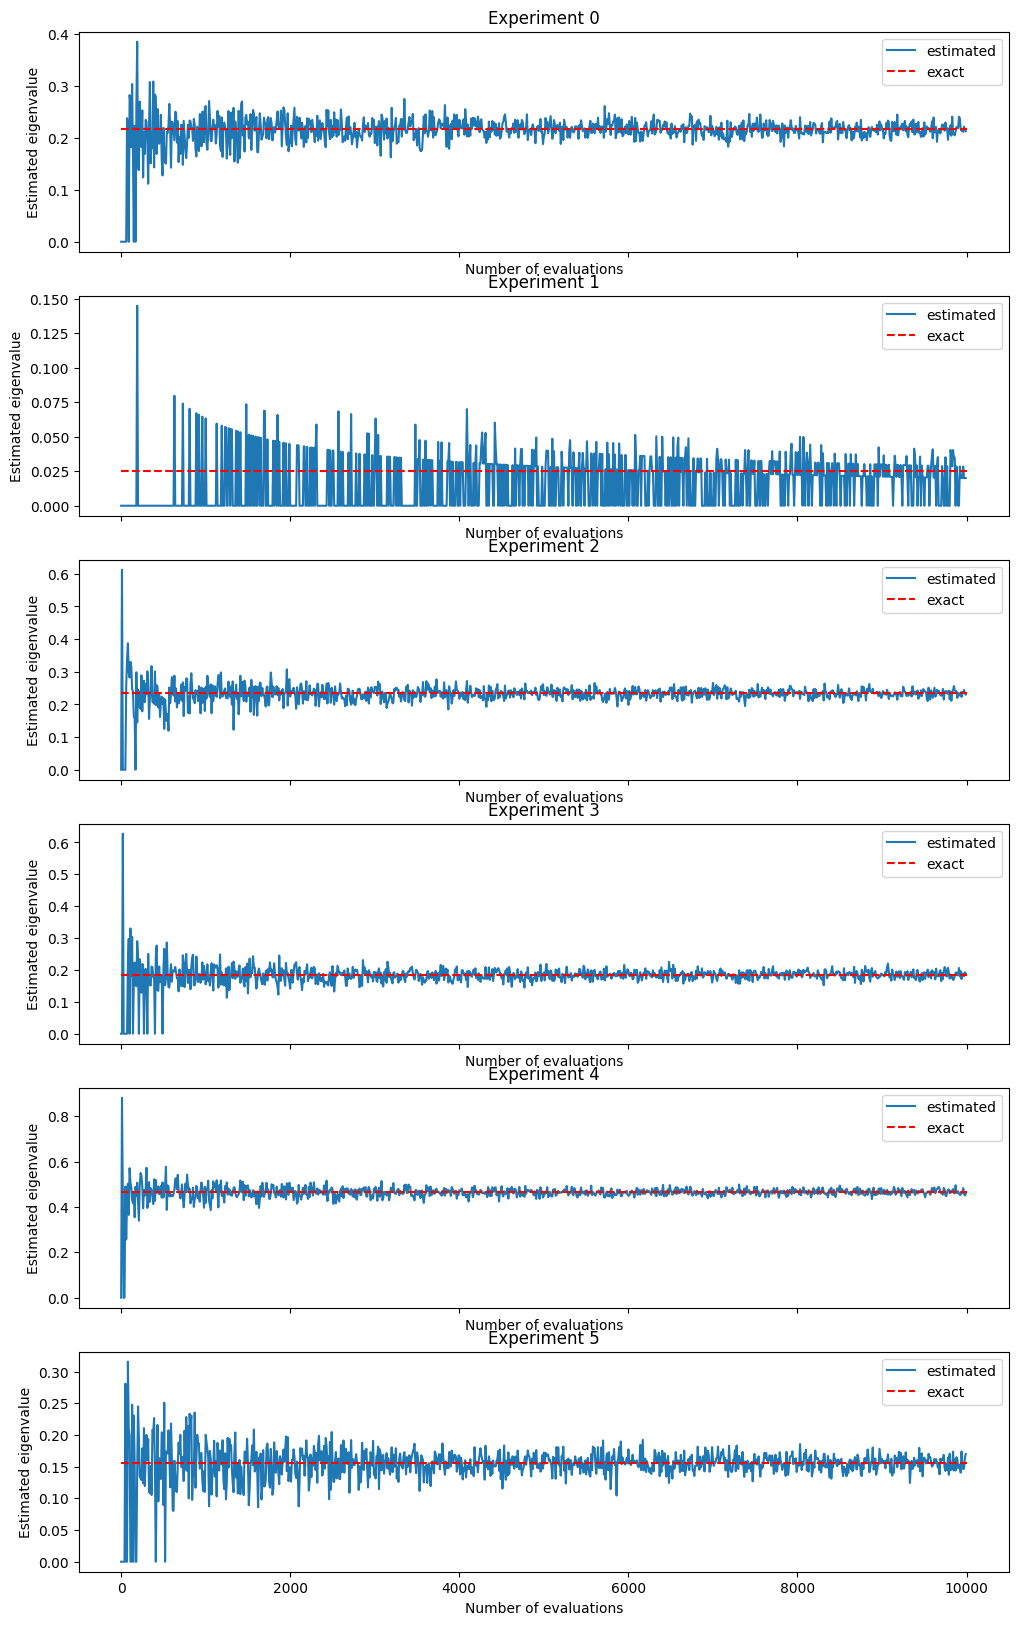

In [4]:
# create a subplot for every experiment
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=num_random_matrices, ncols=1, figsize=(12, 20), sharex=True, sharey=False)

for i, (iterations, estimations, exact) in enumerate(all_experiments):
    axs[i].plot(iterations, estimations, label='estimated')
    axs[i].hlines(exact, 0, max_iterations, colors='r', linestyles='dashed', label='exact')
    axs[i].set_title(f'Experiment {i}')
    axs[i].set_xlabel('Number of evaluations')
    axs[i].set_ylabel('Estimated eigenvalue')
    axs[i].legend()

plt.show()



## Note: This phase estimation algorithm - as it is now - does *not* work for negative eigenvalues.
Since the eigenvalue of $H_j$ is given by $2arcos(\sqrt{P[qubit = 0]})$ then the estimation can only be positive!

#TODO: fix that

In [5]:
# For now, let us test QDRIFT:
import random
import numpy as np

class oracle:
    '''
    oracle function SAMPLE() that returns an
value j from a probability distribution
    '''
    def __init__(self, coefficients):
        self.coefficients = coefficients
        
    def sample(self):
        # return index i of a term in the Hamiltonian, such that the probability or returning
        # any index i is proportional to the coefficient of the term in the Hamiltonian decomposition
        coeffs_normalized = [coeff / sum(self.coefficients) for coeff in self.coefficients]
        indexes_to_return = [i for i in range(len(coeffs_normalized))]
        return np.random.choice(indexes_to_return, p=coeffs_normalized)

    

def qdrift_simple(H_list, oracle, epsilon, t, coeffs):
    upper_bound = sum(coeffs) # lambda in article
    print(f'upper bound: {upper_bound}')
    N = np.ceil((2 * upper_bound**2 * t **2) / epsilon)
    print(f'calculated N: {N}')
    i = 0
    v_lst = []

    while i < N:
        j = oracle.sample()
        v_lst.append(scipy.linalg.expm(1j * upper_bound * H_list[j] * t) / N)
        i += 1
    return v_lst, N

In [15]:
TERMS_IN_HAMILTONIAN = 1
QDRIFT_ITERATIONS = 100
TIME_EVOLUTION = 1000
hermitian_lst = [generate_random_hermitian() for _ in range(TERMS_IN_HAMILTONIAN)]
coefficients = [random.randint(1, 7) / 7 for _ in range(TERMS_IN_HAMILTONIAN)]
full_hamiltonian = sum([coefficients[i] * hermitian_lst[i] for i in range(TERMS_IN_HAMILTONIAN)])
print(full_hamiltonian)

qdrift_qiskit_version = QDrift(reps=QDRIFT_ITERATIONS, insert_barriers=True, seed=42)
# first we need to turn our list of hermitians into a list of Pauli or SparsePauliOp objects
operator_lst = [SparsePauliOp.from_operator(coefficients[i] * hermitian_lst[i]) for i in range(TERMS_IN_HAMILTONIAN)]
evolution_gate_to_simulate = PauliEvolutionGate(operator=operator_lst, time=TIME_EVOLUTION)
qc_qdrift = qdrift_qiskit_version.synthesize(evolution_gate_to_simulate)
qc_qdrift.draw(output='mpl')

[[0.6540958 +0.j         0.10418667+0.35604687j]
 [0.10418667-0.35604687j 0.30146816+0.j        ]]


KeyboardInterrupt: 

# Step 2: Approximate the unitary propagator $U$ of the quantum system
## You can't always get what you want...
aka $-i\hbar\frac{\partial | \psi (t)\rangle}{\partial t} = \hat{H}  | \psi (t)\rangle \iff | \psi(t) \rangle = e^{-i \hat{H}t} | \psi(0) \rangle$
## but if you try sometimes, you might find...you get what you need:
$e^{-i \hat{H}t} | \psi(0) \rangle \approx U  | \psi(0) \rangle$

where $U$ is something we can implement in a quantum computer, given some not so cringe assumptions - $\hat{H}$ is k-local and each locat term is Hermitian, etc - and clever math and computer science (in this case, QDRIFT)

In [9]:
# Let's actually just use the Qdrift implementation we already have:
from scripts.algo.qdrift import QDrift
from scripts.database import *
data = DataManager("../data")  # Create DataManager instance
data_hubbad_model = data.load('hubbard', "h_2") # load the hubbard model
data_hubbad_model.decompose(-1, 2) # t = +1 and u = +2 

hamiltonian_decomposition = data_hubbad_model.get_decomp()
hamiltonian_decomposition


Data loaded from ../data\hubbard/h_2.pkl


DecomposedHamiltonian(3, [Tensor(1, [[0. 1.]
 [1. 0.]], [(1, 0, 1), (0, 1, 1)]), Tensor(2, [[1. 0.]
 [0. 1.]], [(0, 0, 1), (1, 1, 1)])], {'obt': Tensor(1, [[0. 1.]
 [1. 0.]], [(1, 0, 1), (0, 1, 1)]), 'tbt': Tensor(2, [[1. 0.]
 [0. 1.]], [(0, 0, 1), (1, 1, 1)])})

In [ ]:
from qiskit_aer import Aer
QDRIF_ITERATIONS = 50
PHASE_ESTIMATION_ITERATIONS = 100000
NUM_TRIALS = 10
T = 6000
print(f"Starting QDrift for Hamiltonian: {data_hubbad_model.get_decomp()}") 
estimations = []
true_eigenvalues_avg = []

for _ in range(NUM_TRIALS):

    homemade_qdrift = QDrift(h=data_hubbad_model, t=T)
    sampled_hermitians, estimated_unitaries =  homemade_qdrift.qdrift(N=QDRIF_ITERATIONS)
    true_eigenvalues_lst = []
    estimated_eigenvalues_lst = []

    for i in range(len(sampled_hermitians)):

        true_eigenvalues, true_eigenvectors = scipy.linalg.eig(sampled_hermitians[i])
        ground_state_eigenvector = true_eigenvectors[:, np.argmin(true_eigenvalues)]
        true_eigenvalues_lst.append(min(true_eigenvalues)) # we only care about the smallest eigenvalue (ground state)
        curr_U = estimated_unitaries[i]
        p_0, qc = iterative_phase_estimation_v2(U=curr_U, eigenstate=ground_state_eigenvector, 
                                                num_evals=PHASE_ESTIMATION_ITERATIONS, 
                                                backend=Aer.get_backend('qasm_simulator') , num_qubits=1)

        estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0)) 
        estimated_eigenvalues_lst.append(estimated_eigenvalue)

    avg_estimated_eigenvalue = np.mean(estimated_eigenvalues_lst)
    avg_true_eigenvalue = np.mean(true_eigenvalues_lst)
    error = abs(avg_estimated_eigenvalue - avg_true_eigenvalue)
    print(f"Estimated eigenvalue: {avg_estimated_eigenvalue} \n True eigenvalue: {avg_true_eigenvalue} \n Error: {error}")
    estimations.append(avg_estimated_eigenvalue)
    true_eigenvalues_avg.append(avg_true_eigenvalue)

In [15]:
for i in range(NUM_TRIALS):
    print(f"Estimated eigenvalue: {estimations[i]} \nTrue eigenvalue: {true_eigenvalues_avg[i]} \nError: {abs(estimations[i] - true_eigenvalues_avg[i])}\n")

print(f"Highest error: {max([abs(estimations[i] - true_eigenvalues_avg[i]) for i in range(NUM_TRIALS)])} \nAverage error: {np.mean([abs(estimations[i] - true_eigenvalues_avg[i]) for i in range(NUM_TRIALS)])}")

Estimated eigenvalue: 2.354159156223887 
True eigenvalue: (1.1+0j) 
Error: 1.2541591562238867

Estimated eigenvalue: 2.3252171963827215 
True eigenvalue: (0.98+0j) 
Error: 1.3452171963827215

Estimated eigenvalue: 2.2405358336373897 
True eigenvalue: (0.62+0j) 
Error: 1.6205358336373896

Estimated eigenvalue: 2.3537805290198466 
True eigenvalue: (1.1+0j) 
Error: 1.2537805290198465

Estimated eigenvalue: 2.29760909362685 
True eigenvalue: (0.86+0j) 
Error: 1.43760909362685

Estimated eigenvalue: 2.3110241923504704 
True eigenvalue: (0.92+0j) 
Error: 1.3910241923504705

Estimated eigenvalue: 2.354428997789711 
True eigenvalue: (1.1+0j) 
Error: 1.2544289977897107

Estimated eigenvalue: 2.283219198881563 
True eigenvalue: (0.8+0j) 
Error: 1.483219198881563

Estimated eigenvalue: 2.311553066792452 
True eigenvalue: (0.92+0j) 
Error: 1.391553066792452

Estimated eigenvalue: 2.2975610593352704 
True eigenvalue: (0.86+0j) 
Error: 1.4375610593352706

Highest error: 1.6205358336373896 
Average e

In [4]:
from scripts.database.data_interface import *
from qiskit_aer import Aer
QDRIF_ITERATIONS = 50
PHASE_ESTIMATION_ITERATIONS = 100000
NUM_TRIALS = 10
T = 6000
TERMS_IN_HAMILTONIAN = 10
estimations = []
true_eigenvalues_avg = []

# Now let's try with a random Hamiltonian; we just gotta make it fit the API thar our QDrift implementation expects
hermitian_lst = [generate_random_hermitian() for _ in range(TERMS_IN_HAMILTONIAN)]
coefficients = [random.randint(1, 7) / 7 for _ in range(TERMS_IN_HAMILTONIAN)]
full_hamiltonian = sum([coefficients[i] * hermitian_lst[i] for i in range(TERMS_IN_HAMILTONIAN)])

# wrap the Hamlitonian in a Hamiltonian object
full_hamiltonian = Hamiltonian(coefficient=1, matrix=full_hamiltonian, matrix_1d=None)
full_hamiltonian.set_decomp(names=[f"h_{i}" for i in range(TERMS_IN_HAMILTONIAN)], 
                            terms=[Tensor(coefficient=coefficients[i], matrix=hermitian_lst[i], matrix_1d=None) for i in range(TERMS_IN_HAMILTONIAN)])

for _ in range(NUM_TRIALS):
    
    homemade_qdrift = QDrift(h=full_hamiltonian, t=T)
    sampled_hermitians, estimated_unitaries =  homemade_qdrift.qdrift(N=QDRIF_ITERATIONS)
    true_eigenvalues_lst = []
    estimated_eigenvalues_lst = []

    for i in range(len(sampled_hermitians)):

        true_eigenvalues, true_eigenvectors = scipy.linalg.eig(sampled_hermitians[i])
        ground_state_eigenvector = true_eigenvectors[:, np.argmin(true_eigenvalues)]
        true_eigenvalues_lst.append(min(true_eigenvalues)) # we only care about the smallest eigenvalue (ground state)
        curr_U = estimated_unitaries[i]
        p_0, qc = iterative_phase_estimation_v2(U=curr_U, eigenstate=ground_state_eigenvector, 
                                                num_evals=PHASE_ESTIMATION_ITERATIONS, 
                                                backend=Aer.get_backend('qasm_simulator') , num_qubits=1)

        estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0)) 
        estimated_eigenvalues_lst.append(estimated_eigenvalue)

    avg_estimated_eigenvalue = np.mean(estimated_eigenvalues_lst)
    avg_true_eigenvalue = np.mean(true_eigenvalues_lst)
    error = abs(avg_estimated_eigenvalue - avg_true_eigenvalue)
    print(f"Estimated eigenvalue: {avg_estimated_eigenvalue} \n True eigenvalue: {avg_true_eigenvalue} \n Error: {error}")
    estimations.append(avg_estimated_eigenvalue)
    true_eigenvalues_avg.append(avg_true_eigenvalue)




{'0': 97806, '1': 2194}
{'0': 88763, '1': 11237}
{'0': 97976, '1': 2024}
{'1': 92085, '0': 7915}
{'1': 92025, '0': 7975}
{'1': 92270, '0': 7730}
{'1': 81002, '0': 18998}
{'1': 27864, '0': 72136}
{'1': 80334, '0': 19666}
{'1': 80848, '0': 19152}
{'1': 92129, '0': 7871}
{'1': 92187, '0': 7813}
{'1': 92214, '0': 7786}
{'0': 72040, '1': 27960}
{'1': 80881, '0': 19119}
{'0': 19273, '1': 80727}
{'0': 88762, '1': 11238}
{'0': 78716, '1': 21284}
{'1': 28209, '0': 71791}
{'0': 72020, '1': 27980}
{'0': 88731, '1': 11269}
{'0': 71864, '1': 28136}
{'1': 28244, '0': 71756}
{'0': 88666, '1': 11334}
{'1': 92264, '0': 7736}
{'0': 97920, '1': 2080}
{'1': 21097, '0': 78903}
{'1': 11274, '0': 88726}
{'0': 88725, '1': 11275}
{'1': 92238, '0': 7762}
{'1': 11329, '0': 88671}
{'1': 80973, '0': 19027}
{'0': 97786, '1': 2214}
{'0': 19502, '1': 80498}
{'0': 7890, '1': 92110}
{'0': 88690, '1': 11310}
{'0': 97848, '1': 2152}
{'1': 80814, '0': 19186}
{'1': 92155, '0': 7845}
{'1': 92191, '0': 7809}
{'1': 80881, '0'

In [5]:
for i in range(NUM_TRIALS):
    print(f"Estimated eigenvalue: {estimations[i]} \nTrue eigenvalue: {true_eigenvalues_avg[i]} \nError: {abs(estimations[i] - true_eigenvalues_avg[i])}\n")

print(f"Highest error: {max([abs(estimations[i] - true_eigenvalues_avg[i]) for i in range(NUM_TRIALS)])} \nAverage error: {np.mean([abs(estimations[i] - true_eigenvalues_avg[i]) for i in range(NUM_TRIALS)])}")

Estimated eigenvalue: 1.5325996380767863 
True eigenvalue: (0.13295446234931288-9.846531744030216e-19j) 
Error: 1.3996451757274735

Estimated eigenvalue: 1.4276683696443402 
True eigenvalue: (0.1261645759505323+4.866008893752422e-19j) 
Error: 1.3015037936938079

Estimated eigenvalue: 1.448508265645401 
True eigenvalue: (0.14195962998591236+4.258655900348327e-20j) 
Error: 1.3065486356594886

Estimated eigenvalue: 1.3870963642725198 
True eigenvalue: (0.1530101260778088-1.5617992696833657e-18j) 
Error: 1.234086238194711

Estimated eigenvalue: 1.1679290306860008 
True eigenvalue: (0.1394117970633959+4.355991465220162e-18j) 
Error: 1.028517233622605

Estimated eigenvalue: 1.305215473759806 
True eigenvalue: (0.14851958309379296+5.679072098298579e-19j) 
Error: 1.1566958906660132

Estimated eigenvalue: 1.2226722983294025 
True eigenvalue: (0.157361617586223+8.447056356306725e-19j) 
Error: 1.0653106807431796

Estimated eigenvalue: 1.2973049050852767 
True eigenvalue: (0.15733365440560007+8.81

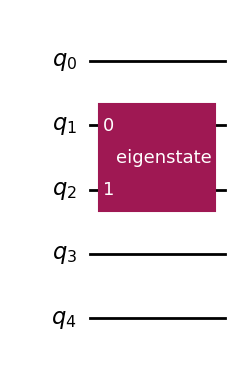

In [10]:
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit import QuantumCircuit, transpile
new_qc = QuantumCircuit(5)
eigenstate_circuit = QuantumCircuit(2, name='eigenstate')
new_qc.append(eigenstate_circuit, [1,2])
new_qc.draw("mpl")

In [ ]:
# Generate random 4x4 Hermitian matrix
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, circuit_drawer
from typing import Optional, Union
import random
import numpy as np
from functools import reduce
import scipy.linalg
import pandas as pd

# Type aliases
coefficient = float
Hamiltonian = list[tuple[coefficient, Pauli]]

# Function to generate a random Hamiltonian
def generate_random_hamiltonian(num_qubits, num_terms) -> Hamiltonian:
    pauli_matrices = [Pauli('X'), Pauli('Z'), Pauli('I')]
    hamiltonian_terms = []
    for _ in range(num_terms):
        pauli_string = reduce(lambda x, y: x.tensor(y),
                              random.choices(pauli_matrices, k=num_qubits))
        hamiltonian_terms.append((random.uniform(0, 1), pauli_string))
    return hamiltonian_terms

H = generate_random_hamiltonian(2, 1)

H[0][0] 

0.5957006777023983